In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [2]:
bs = 32

In [3]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# img = images[0]
img = np.squeeze(images[0])

In [15]:
img.shape

(28, 28)

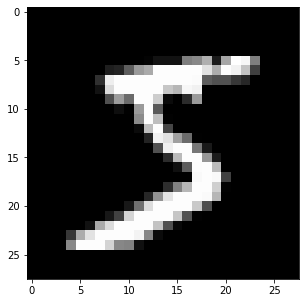

In [16]:
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. The encoder and decoder will be made of two linear layers, each. The depth dimensions should change as follows: 784 inputs > encoding_dim > 784 outputs. All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

In [119]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super().__init__()
        self.encoder = nn.Linear(28*28, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 28*28)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x.view(-1, 1, 28, 28)

# initialize the NN
encoding_dim = 10
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=10, bias=True)
  (decoder): Linear(in_features=10, out_features=784, bias=True)
)


In [120]:
loss_func = nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)

In [13]:
def loss_batch(model, loss_function, xb, _, opt=None):
    loss = loss_function(model(xb),xb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

In [7]:
def fit(epochs, model, loss_function, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        model.train()
        for xb, _ in train_dl:
            loss_batch(model, loss_function, xb, xb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_function, xb, xb) for xb, _ in valid_dl]
            )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f"Epoch: {epoch}, Val Loss: {val_loss}")

In [123]:
xb, yb = next(iter(train_loader))
model(xb).shape

torch.Size([32, 1, 28, 28])

In [124]:
fit(10, model, loss_func, opt, train_loader, test_loader)

Epoch: 0, Val Loss: 0.20428880077962297
Epoch: 1, Val Loss: 0.08338257020559554
Epoch: 2, Val Loss: 0.07254999235700875
Epoch: 3, Val Loss: 0.07052208752201769
Epoch: 4, Val Loss: 0.06930030212282373
Epoch: 5, Val Loss: 0.06860189819440674
Epoch: 6, Val Loss: 0.067921574789876
Epoch: 7, Val Loss: 0.06728120723043006
Epoch: 8, Val Loss: 0.06655339941906091
Epoch: 9, Val Loss: 0.06593054227126292


In [15]:
def show_samples(model, n_samples=10):
    model.eval()
    with torch.no_grad():
        xb, _ = next(iter(test_loader))
        xb= xb[:n_samples]
        pred = np.squeeze(model(xb).numpy(), axis=1)
        orig = np.squeeze(xb.numpy(),axis=1)
        fig, ax = plt.subplots(n_samples, 2, figsize=(4,15))
        for i, row in enumerate(ax):
            row[0].imshow(orig[i], cmap='gray',)
            row[0].axis('off')
            row[1].imshow(pred[i], cmap='gray')
            row[1].axis('off')
        plt.show()

/home/niyas/.local/share/virtualenvs/pytorch-notes-5uqAFV5U/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


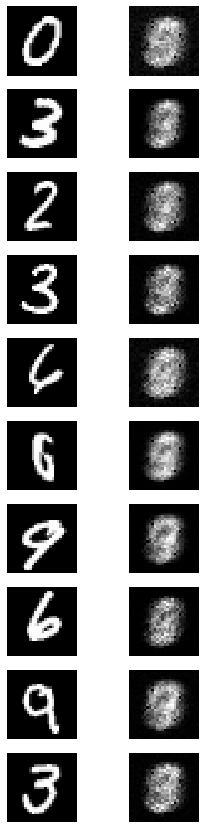

In [181]:
show_samples(model)

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        
        # encoder
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # decoder
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))        
        return x

In [11]:
model_conv = ConvAutoencoder()
opt_conv= torch.optim.SGD(model_conv.parameters(), lr=0.01, momentum=.9)
loss_func = nn.MSELoss()

In [14]:
fit(10, model_conv, loss_func, opt_conv, train_loader, test_loader)

Epoch: 0, Val Loss: 0.08514482178688049
Epoch: 1, Val Loss: 0.040789821481704715
Epoch: 2, Val Loss: 0.03391379549503326
Epoch: 3, Val Loss: 0.027569907331466675
Epoch: 4, Val Loss: 0.025439806538820265
Epoch: 5, Val Loss: 0.023639033421874046
Epoch: 6, Val Loss: 0.022169080486893655
Epoch: 7, Val Loss: 0.021135175555944442
Epoch: 8, Val Loss: 0.02034569157063961
Epoch: 9, Val Loss: 0.01979232830107212


/home/niyas/.local/share/virtualenvs/pytorch-notes-5uqAFV5U/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


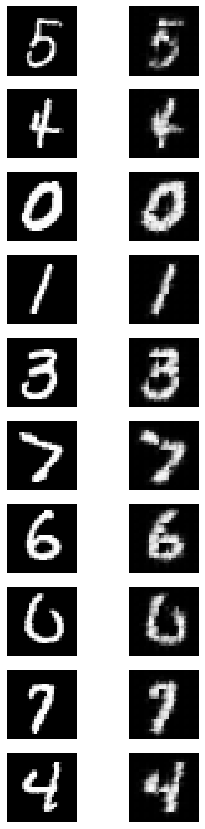

In [16]:
show_samples(model_conv, 10)

In [19]:
class MNISTAutoEncoderDataset(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, download=False):
        super().__init__(root=root, train=train, transform=transform, target_transform=None, download=download)
    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            /img = self.transform(img)

        return img, img

In [26]:
data = MNISTAutoEncoderDataset('data/', train=True, download=True)